In [8]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

In [9]:
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="langchain_community.vectorstores.faiss", lineno=0)

## Step 1A: Get the transcript from a YouTube video (Indexing- Document Ingestion)

In [10]:
video_id = "OpUEEr-F5dY"

try:
    ytt_api = YouTubeTranscriptApi()

    # fetch English or Hindi transcript (priority order)
    fetched_transcript = ytt_api.fetch(video_id, languages=["en"])

    # Convert to plain text
    transcript = " ".join([snippet.text for snippet in fetched_transcript])
    print(transcript)

except TranscriptsDisabled:
    print("No captions available for this video.")

On Wednesday, September 10th, Charlie Kirk was murdered in broad daylight. He was a prominent right-wing political figure in the US and had just started a new campus tour. His first stop was at Utah Valley University in Orin. He left behind a wife and two children. Immediately after his assassination, the hunt for his killer began. Now, authorities have identified a suspect. This is how he was caught. If you read this, you are gay. L M A O capital O wo what's this question mark? >> For an initial mapping of the video, check out Ho's video. Link is in the description. Kirk got into politics really young and started Turning Point USA when he was just 18. The organization is committed to promoting right-wing views in schools and universities. Kirk reached millions through social media and his podcast. He tooured colleges to debate students and had become a close Trump ally. He is said to have played an important role in Trump's re-election. Phone footage from the event shows the likely sh

## Step 1B: (Indexing- Text Splitting)

In [11]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=80,
)

chunks = splitter.create_documents([transcript])

In [12]:
len(chunks)

11

In [13]:
chunks[0]

Document(metadata={}, page_content="On Wednesday, September 10th, Charlie Kirk was murdered in broad daylight. He was a prominent right-wing political figure in the US and had just started a new campus tour. His first stop was at Utah Valley University in Orin. He left behind a wife and two children. Immediately after his assassination, the hunt for his killer began. Now, authorities have identified a suspect. This is how he was caught. If you read this, you are gay. L M A O capital O wo what's this question mark? >> For an initial mapping of the video, check out Ho's video. Link is in the description. Kirk got into politics")

## Step 1C: (Indexing- Creating Embeddings and Vector Store)

In [14]:
#dengcao/Qwen3-Embedding-0.6B:Q8_0
#nomic-embed-text:v1.5
embedding = OllamaEmbeddings(
    model="nomic-embed-text:v1.5"
)

vector_store = FAISS.from_documents(
    documents=chunks,
    embedding=embedding,
)

In [15]:
vector_store.index_to_docstore_id

{0: '3833f58d-56d5-4c30-a40d-cc53a92e0cda',
 1: '48d2d8c4-6f00-4162-a8b0-ee2a07c36aae',
 2: 'f8433166-558a-4354-8989-447dd89fe5e3',
 3: 'be4ee8b5-0dd6-4c75-a4f2-a788282bce64',
 4: '69808e55-a6ea-4e71-ba5d-28bd6bafd180',
 5: '864e900e-2ab9-4e0e-a990-b1de2b77836e',
 6: '0c5b848d-9cb0-409f-acc4-5f14be421b38',
 7: '72451bb1-d309-40c3-b6ad-9f4b934e7501',
 8: '65a2e5f6-5edb-408e-9a8e-2462261a7deb',
 9: 'cfbc16a8-63de-484b-ad09-bd792b4b4d80',
 10: '7d097556-1760-482a-8470-270ed548f306'}

In [16]:
vector_store.get_by_ids(["1e432823-2429-4cf9-9746-fea93a117024"])

[]

## Step 2: Retrieval

In [17]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k":3})

In [18]:
retriever

VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001E1810CF620>, search_kwargs={'k': 3})

In [19]:
retriever.invoke("What was found on discord")

[Document(id='864e900e-2ab9-4e0e-a990-b1de2b77836e', metadata={}, page_content="reportedly showed Discord messages to investigators. According to CNN, the messages included Robinson stating a need to retrieve a rifle from a drop point, leaving the rifle in a bush, visually watching the area where a rifle was left, reference to having left the rifle wrapped in a towel, reference to engraving bullets and the rifle being unique, mention of Robinson changing outfits. Trump makes the capture public on Fox and Friends. >> Looking real good. They have the person that they wanted. >> Next, Utah's governor steps in front of cameras. Friday morning. >> Good morning, ladies and"),
 Document(id='3833f58d-56d5-4c30-a40d-cc53a92e0cda', metadata={}, page_content="On Wednesday, September 10th, Charlie Kirk was murdered in broad daylight. He was a prominent right-wing political figure in the US and had just started a new campus tour. His first stop was at Utah Valley University in Orin. He left behind 

In [20]:
retriever.invoke("Who were the suspects?")

[Document(id='be4ee8b5-0dd6-4c75-a4f2-a788282bce64', metadata={}, page_content='here. Shortly after, the authorities released photos of the suspect and a video where he can be seen climbing off the roof and running off into the surrounding neighborhood. The FBI offers a $100,000 reward for leads. At this point, a manhunt of tremendous scale is unfolding. Heavily armed officers are at the scene. Authorities confirm that they found a high-powered bolt-action rifle in a wooded area. Increasingly, the FBI is under pressure. Two suspects are brought into custody, but released shortly after. 24 hours pass and no one has been caught. Meanwhile, the suspect, Tyler Robinson,'),
 Document(id='3833f58d-56d5-4c30-a40d-cc53a92e0cda', metadata={}, page_content="On Wednesday, September 10th, Charlie Kirk was murdered in broad daylight. He was a prominent right-wing political figure in the US and had just started a new campus tour. His first stop was at Utah Valley University in Orin. He left behind a

## Step 3: Augmentation - Attach external documents/context with the prompt

In [21]:
model = ChatOllama(model="mistral:latest", temperature=0.2)

In [22]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    You are a helpful assistant that helps people find information.
    Use the following pieces of context to answer the question at the end.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    {context}
    Question: {question}
    """,
)

In [23]:
question = "Whats the video about? Did the police catch the suspects?"
retrieved_docs = retriever.invoke(question)

In [24]:
retrieved_docs

[Document(id='be4ee8b5-0dd6-4c75-a4f2-a788282bce64', metadata={}, page_content='here. Shortly after, the authorities released photos of the suspect and a video where he can be seen climbing off the roof and running off into the surrounding neighborhood. The FBI offers a $100,000 reward for leads. At this point, a manhunt of tremendous scale is unfolding. Heavily armed officers are at the scene. Authorities confirm that they found a high-powered bolt-action rifle in a wooded area. Increasingly, the FBI is under pressure. Two suspects are brought into custody, but released shortly after. 24 hours pass and no one has been caught. Meanwhile, the suspect, Tyler Robinson,'),
 Document(id='3833f58d-56d5-4c30-a40d-cc53a92e0cda', metadata={}, page_content="On Wednesday, September 10th, Charlie Kirk was murdered in broad daylight. He was a prominent right-wing political figure in the US and had just started a new campus tour. His first stop was at Utah Valley University in Orin. He left behind a

In [25]:
context_text = "\n".join([doc.page_content for doc in retrieved_docs])

In [26]:
final_prompt = prompt.format(context=context_text, question=question)

## Step 4: Generation - Get the final answer from LLM

In [27]:
result = model.invoke(final_prompt)

In [28]:
print(result.content)

 The video is about the shooting incident of Charlie Kirk, a prominent right-wing political figure in the US. In the video, you can see the shooter firing a single shot at Kirk, who was engaged in a discussion with a student. After the shooting, the suspect is seen sprinting off the same roof. However, it's not clear from the provided context whether the police have caught the suspect or not. The text mentions that heavily armed officers are at the scene and authorities confirm finding a high-powered bolt-action rifle, but there's no information about the arrest of the suspect.


## Step 5: Building a Chain to combine all the steps and create a Pipeline

In [29]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [30]:
def format_docs (retrieved_docs):
    context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
    return context_text

parser = StrOutputParser()


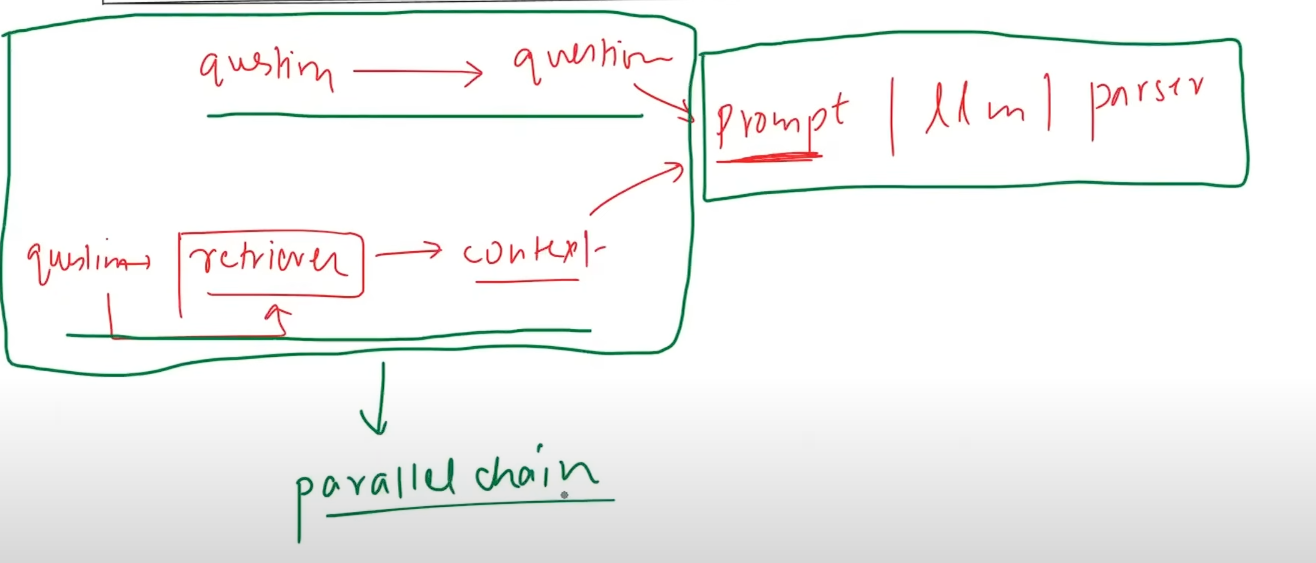

In [31]:
parallel_chain = RunnableParallel(
    {
        "context": retriever | RunnableLambda(format_docs),
        "question": RunnablePassthrough(),
    }
)

In [32]:
sequential_chain = prompt | model | parser

In [33]:
final_chain =  parallel_chain | sequential_chain

In [34]:
result = final_chain.invoke("Who is the major suspect? What all do we know of them")

In [35]:
print(result)

 The major suspect in the murder of Charlie Kirk is Tyler Robinson. Here's what we know about him:

1. He is a resident of Washington, Utah, approximately 3 hours away from Utah Valley University where Kirk was murdered.
2. Robinson seems to have told a family member that he shot Kirk, and this information was reported to the authorities by a family friend.
3. The father of Tyler Robinson is believed to be a veteran law enforcement officer.
4. Robinson turned himself in late Thursday evening in St. George, which is about 250 miles or 400 km from Utah Valley University.
5. Discord messages reportedly showed by Robinson's roommate were shown to investigators.
6. He was identified as the suspect after Kirk's murder on Wednesday, September 10th.
